In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

import metpy.calc as mpcalc

#### Define case and path

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [3]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

#### Get grid

In [4]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

In [5]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT
area_x1=ds_grid_x1.TAREA
area_m_x1=ds_grid_x1.TAREA * 1e-4
lons_norm_x1 = utils.normal_lons(lons_x1)

#### Define variable list

In [6]:
variables = ['photoC_diaz_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [7]:
def preprocess(ds):
    ds=ds.mean(dim='time')
    return ds

In [8]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  photoC_diaz_zint
starting on  photoC_diat_zint
starting on  photoC_sp_zint
starting on  photoC_cocco_zint


In [9]:
ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")

In [10]:
ds_fosi_x01

<xarray.Dataset>
Dimensions:            (d2: 2, nlat: 2400, nlon: 3600, time: 768, z_t: 62, z_t_150m: 15)
Coordinates:
  * z_t                (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m           (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time               (time) object 1958-01-16 12:15:50.000002 ... 2021-12-1...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    dz                 (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    time_bound         (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    photoC_diaz_zint   (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    photoC_diat_zint   (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    photoC_sp_zint     (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    photoC_cocco_zint  (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>

In [11]:
ds_fosi_x01['photoC_TOT_zint'] = ds_fosi_x01['photoC_cocco_zint'] + ds_fosi_x01['photoC_diat_zint'] + ds_fosi_x01['photoC_diaz_zint'] + ds_fosi_x01['photoC_sp_zint']

In [12]:
ds_fosi_x01 = ds_fosi_x01.drop(['photoC_cocco_zint','photoC_diat_zint','photoC_diaz_zint','photoC_sp_zint'])

### spin up dask

In [13]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='06:00:00',
        interface="ext",  # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [14]:
cluster, client = get_ClusterClient()
cluster.scale(16) 

In [15]:
client

Client Scheduler: tcp://128.117.208.109:35737 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Resample for annual means

In [16]:
ones = np.full((2400,3600),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

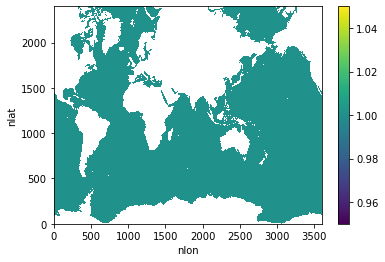

In [17]:
ones.plot()

In [18]:
ones_x1 = np.full((384,320),1,dtype=int)
ones_x1 = xr.DataArray(ones_x1,dims=('nlat','nlon'))
ones_x1 = ones_x1.where(ds_grid_x1.REGION_MASK>0)

### Read in LME masks for 0.1° and 1°

In [19]:
ds_lme_x01 = xr.open_dataset('/glade/u/home/kristenk/scope_analysis/data/LME-mask-POP_tx0.1v3.nc')

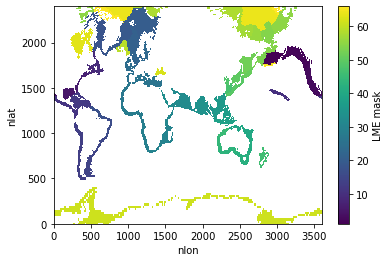

In [20]:
ds_lme_x01.lme_mask.plot()

In [21]:
ds_lme_x1 = xr.open_dataset('/glade/u/home/kristenk/scope_analysis/data/LME-mask-POP_gx1v6.nc')

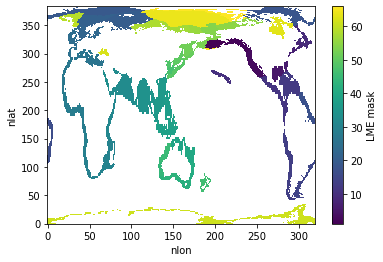

In [22]:
ds_lme_x1.lme_mask.plot()

### Now read in x1 data

In [23]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'

In [24]:
variables = ['photoC_TOT_zint']

In [25]:
ds_fosi_x1 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x1 = xr.merge([ds_fosi_x1,ds_tmp])

starting on  photoC_TOT_zint


In [26]:
ds_fosi_x1["time"] = ds_fosi_x1.time_bound.compute().mean(dim="d2")

## Make a climatology for NPP using the x1, see which month NPP peaks in each region, then make timeseries for that particular month

In [27]:
ds_clim_x1 = ds_fosi_x1.groupby('time.month').mean('time')

In [28]:
ds_clim_x1.photoC_TOT_zint

<xarray.DataArray 'photoC_TOT_zint' (month: 12, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(12, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

In [29]:
#### Canary Current (27), Guinea Current (28), Benguela Upwelling (29)
lme_nums = [27,28,29]

In [30]:
lme_clim_dict = {}

for lme in lme_nums:
    
    print('lme = ', lme)
    
    mask_x1 = ones_x1.where(ds_lme_x1.lme_mask == lme)
    
    masked_area_x1 = area_m_x1.where(ds_lme_x1.lme_mask == lme)
    
    ds_tmp = xr.Dataset()
    
    for v in variables:
        
        #### annual mean x1
        masked_var = ds_clim_x1[v].where(mask_x1==1)

        ds_tmp[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))
        
    lme_clim_dict[lme] = ds_tmp

lme =  27
lme =  28
lme =  29


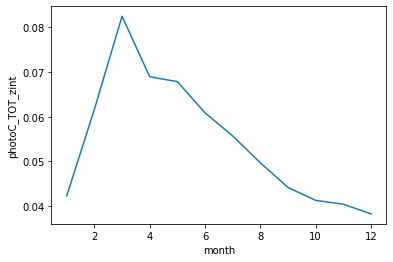

In [31]:
lme_clim_dict[27].photoC_TOT_zint.plot()

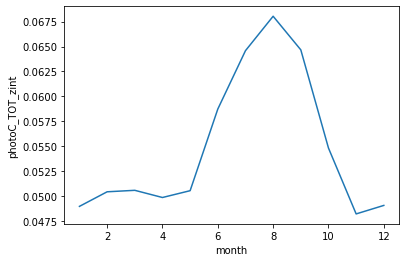

In [32]:
lme_clim_dict[28].photoC_TOT_zint.plot()

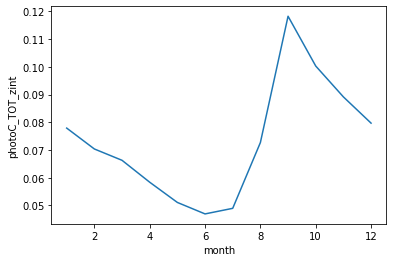

In [33]:
lme_clim_dict[29].photoC_TOT_zint.plot()

### Make just a march timeseries for Canary Current

In [34]:
ds_fosi_x01_march = xr.Dataset()

m=2 #index for march

for year in np.arange(1958,2022,1):
    
    print(year, m)
    
    ds_tmp = ds_fosi_x01.isel(time=m).drop(['time']).compute()
    
    ds_fosi_x01_march = xr.concat([ds_fosi_x01_march, ds_tmp],'time')
    
    m = m + 12

1958 2
1959 14
1960 26
1961 38
1962 50
1963 62
1964 74
1965 86
1966 98
1967 110
1968 122
1969 134
1970 146
1971 158
1972 170
1973 182
1974 194
1975 206
1976 218
1977 230
1978 242
1979 254
1980 266
1981 278
1982 290
1983 302
1984 314
1985 326
1986 338
1987 350
1988 362
1989 374
1990 386
1991 398
1992 410
1993 422
1994 434
1995 446
1996 458
1997 470
1998 482
1999 494
2000 506
2001 518
2002 530
2003 542
2004 554
2005 566
2006 578
2007 590
2008 602
2009 614
2010 626
2011 638
2012 650
2013 662
2014 674
2015 686
2016 698
2017 710
2018 722
2019 734
2020 746
2021 758


In [35]:
ds_fosi_x01_march

<xarray.Dataset>
Dimensions:          (d2: 2, nlat: 2400, nlon: 3600, time: 64, z_t: 62, z_t_150m: 15)
Coordinates:
    TLAT             (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    TLONG            (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
  * z_t              (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m         (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: d2, nlat, nlon, time
Data variables:
    photoC_TOT_zint  (time, nlat, nlon) float32 nan nan nan nan ... nan nan nan
    time_bound       (time, d2) object 1958-03-01 00:00:00 ... 2021-04-01 00:...
    dz               (time, z_t) float32 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04

In [36]:
ds_fosi_x1_march = ds_fosi_x1.sel(time = np.in1d(ds_fosi_x1['time.month'], 3)).compute()

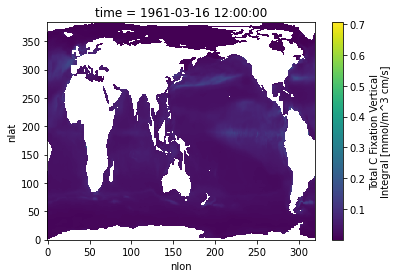

In [37]:
ds_fosi_x1_march.photoC_TOT_zint.isel(time=3).plot()

## Make march timeseries for the Canary Current

In [38]:
lme_nums = [27]

In [39]:
variables = ['photoC_TOT_zint']

In [40]:
#ts_by_lme_dict_x1 = {}
#ts_by_lme_dict_x01 = {}
ts_march_lme_dict_x01 = {}
ts_march_lme_dict_x1 = {}

for lme in lme_nums:
    print('lme = ', lme)
    mask_x1 = ones_x1.where(ds_lme_x1.lme_mask == lme)
    mask_x01 = ones.where(ds_lme_x01.lme_mask == lme)
    
    masked_area_x1 = area_m_x1.where(ds_lme_x1.lme_mask == lme)
    masked_area_x01 = area_m.where(ds_lme_x01.lme_mask == lme)
    
    ds_tmp = xr.Dataset()
    ds_tmp2 = xr.Dataset()
    ds_tmp3 = xr.Dataset()
    ds_tmp4 = xr.Dataset()
    
    for v in variables:
        
        #### annual mean x1
        #masked_var = ds_fosi_x1_ann[v].where(mask_x1==1)
        #ds_tmp[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))
        
        #### march mean x1
        masked_var = ds_fosi_x1_march[v].where(mask_x1==1)

        ds_tmp4[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))
        
        #### annual mean x01
        #masked_var = ds_fosi_x01_ann[v].where(mask_x01==1)
        #ds_tmp2[v] = (masked_var * masked_area_x01).sum(dim=('nlon','nlat')) / masked_area_x01.sum(dim=('nlon','nlat'))
        
        #### march mean x01
        masked_var = ds_fosi_x01_march[v].where(mask_x01==1)

        ds_tmp3[v] = (masked_var * masked_area_x01).sum(dim=('nlon','nlat')) / masked_area_x01.sum(dim=('nlon','nlat'))
        
    #ts_by_lme_dict_x1[lme] = ds_tmp
    #ts_by_lme_dict_x01[lme] = ds_tmp2
    ts_march_lme_dict_x01[lme] = ds_tmp3
    ts_march_lme_dict_x1[lme] = ds_tmp4

lme =  27


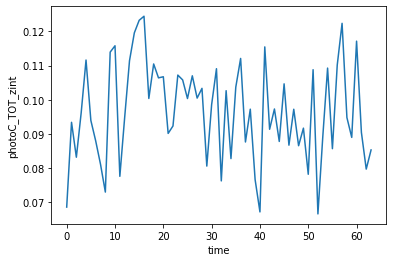

In [41]:
ts_march_lme_dict_x01[27].photoC_TOT_zint.plot()

In [42]:
variables

['photoC_TOT_zint']

In [43]:
years = np.arange(1958,2022,1)
convert = 0.01 * 86400

### NPP peaks in March in Canary current

In [44]:
#ds_fosi_x1.time[410]

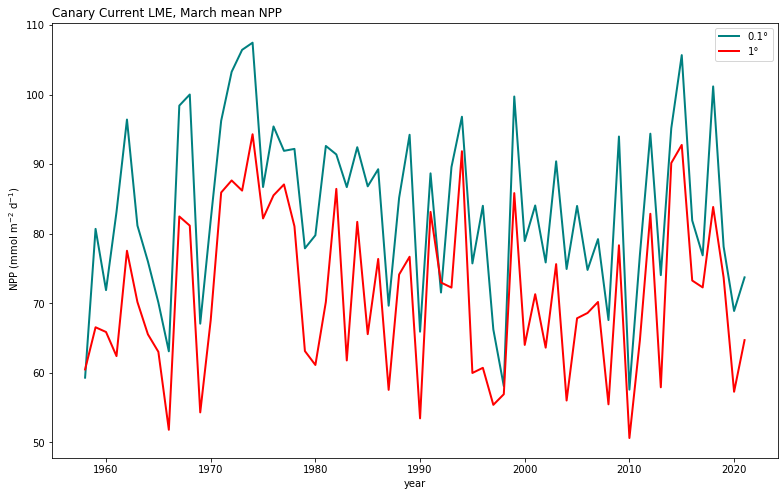

In [69]:
fig = plt.figure(figsize=(13,8))

ax = fig.add_subplot(1,1,1)
ax.set_title('Canary Current LME, March mean NPP',loc='left')
v='photoC_TOT_zint'
ax.plot(years, ts_march_lme_dict_x01[27][v]* convert, color='teal', linewidth=2, label='0.1°')
ax.plot(years, ts_march_lme_dict_x1[27][v]* convert, color='red', linewidth=2, label='1°')
ax.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
ax.legend()


In [46]:
import shapefile as shp
sf = shp.Reader("/glade/work/kristenk/fish-offline/fish-offline/notebooks/data/LMEs66_Offshore")

In [47]:
ds_fosi_x01.time.isel(time=722)

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2018, 3, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2018-03-16 12:00:00

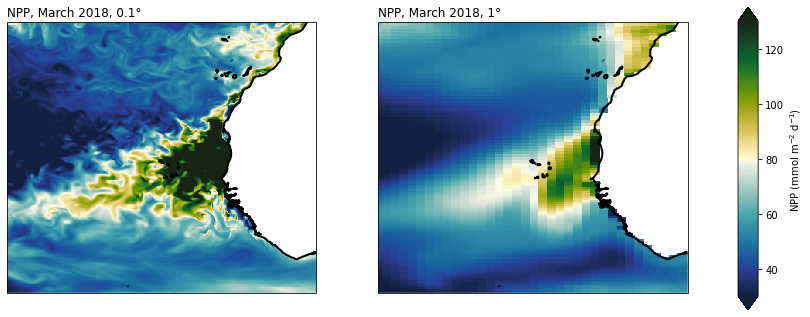

In [48]:
fig = plt.figure(figsize=(14,6))

############### 
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-45, -5, 0, 35], ccrs.PlateCarree())

ax.set_title('NPP, March 2018, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=722)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=130)

# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);
ax.coastlines('10m',linewidth=2)

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-45, -5, 0, 35], ccrs.PlateCarree())

ax.set_title('NPP, March 2018, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=722)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=130)

# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2)
    
ax.coastlines('10m',linewidth=2)

###### NPP colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb_npp = plt.colorbar(pc, cax=cbar_ax,extend='both', label='NPP (mmol m$^{-2}$ d$^{-1}$)')

In [49]:
ds_fosi_x01.time.isel(time=626)

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2010, 3, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2010-03-16 12:00:00

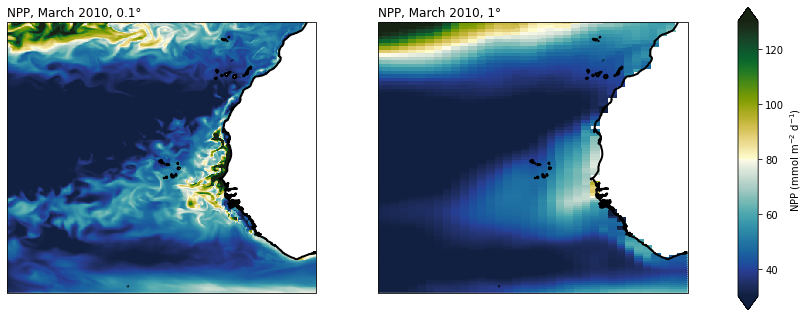

In [50]:
fig = plt.figure(figsize=(14,6))

############### 
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-45, -5, 0, 35], ccrs.PlateCarree())

ax.set_title('NPP, March 2010, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=626)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=130)

# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);
ax.coastlines('10m',linewidth=2)

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-45, -5, 0, 35], ccrs.PlateCarree())

ax.set_title('NPP, March 2010, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=626)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=130)

# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2)
    
ax.coastlines('10m',linewidth=2)

###### NPP colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb_npp = plt.colorbar(pc, cax=cbar_ax,extend='both', label='NPP (mmol m$^{-2}$ d$^{-1}$)')

In [51]:
ds_fosi_x01.time.isel(time=254)

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1979, 3, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1979-03-16 12:00:00

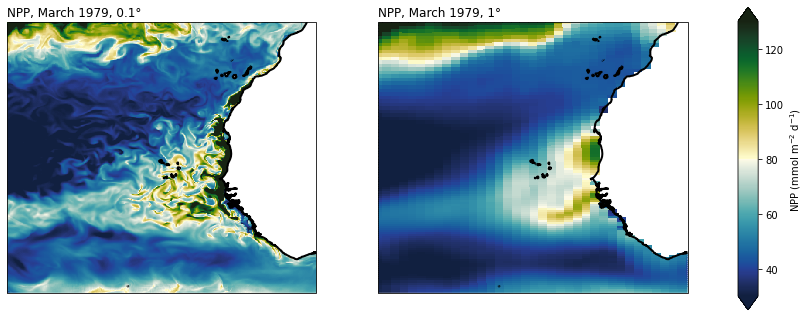

In [52]:
fig = plt.figure(figsize=(14,6))

############### 
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-45, -5, 0, 35], ccrs.PlateCarree())

ax.set_title('NPP, March 1979, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=254)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=130)

# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);
ax.coastlines('10m',linewidth=2)

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-45, -5, 0, 35], ccrs.PlateCarree())

ax.set_title('NPP, March 1979, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=254)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=130)

# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2)
    
ax.coastlines('10m',linewidth=2)

###### NPP colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb_npp = plt.colorbar(pc, cax=cbar_ax,extend='both', label='NPP (mmol m$^{-2}$ d$^{-1}$)')

### Make timeseries of August for Guinea Current

In [53]:
ds_fosi_x01_aug = xr.Dataset()

m=7 #index for march

for year in np.arange(1958,2022,1):
    
    print(year, m)
    
    ds_tmp = ds_fosi_x01.isel(time=m).drop(['time']).compute()
    
    ds_fosi_x01_aug = xr.concat([ds_fosi_x01_aug, ds_tmp],'time')
    
    m = m + 12

1958 7
1959 19
1960 31
1961 43
1962 55
1963 67
1964 79
1965 91
1966 103
1967 115
1968 127
1969 139
1970 151
1971 163
1972 175
1973 187
1974 199
1975 211
1976 223
1977 235
1978 247
1979 259
1980 271
1981 283
1982 295
1983 307
1984 319
1985 331
1986 343
1987 355
1988 367
1989 379
1990 391
1991 403
1992 415
1993 427
1994 439
1995 451
1996 463
1997 475
1998 487
1999 499
2000 511
2001 523
2002 535
2003 547
2004 559
2005 571
2006 583
2007 595
2008 607
2009 619
2010 631
2011 643
2012 655
2013 667
2014 679
2015 691
2016 703
2017 715
2018 727
2019 739
2020 751
2021 763


In [54]:
ds_fosi_x1_aug = ds_fosi_x1.sel(time = np.in1d(ds_fosi_x1['time.month'], 8)).compute()

In [55]:
lme_nums = [28]

#ts_by_lme_dict_x1 = {}
#ts_by_lme_dict_x01 = {}
ts_aug_lme_dict_x01 = {}
ts_aug_lme_dict_x1 = {}

for lme in lme_nums:
    print('lme = ', lme)
    mask_x1 = ones_x1.where(ds_lme_x1.lme_mask == lme)
    mask_x01 = ones.where(ds_lme_x01.lme_mask == lme)
    
    masked_area_x1 = area_m_x1.where(ds_lme_x1.lme_mask == lme)
    masked_area_x01 = area_m.where(ds_lme_x01.lme_mask == lme)
    
    #ds_tmp = xr.Dataset()
    #ds_tmp2 = xr.Dataset()
    ds_tmp3 = xr.Dataset()
    ds_tmp4 = xr.Dataset()
    
    for v in variables:
        
        #### annual mean x1
        #masked_var = ds_fosi_x1_ann[v].where(mask_x1==1)
        #ds_tmp[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))
        
        #### march mean x1
        masked_var = ds_fosi_x1_aug[v].where(mask_x1==1)

        ds_tmp4[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))
        
        #### annual mean x01
        #masked_var = ds_fosi_x01_ann[v].where(mask_x01==1)
        #ds_tmp2[v] = (masked_var * masked_area_x01).sum(dim=('nlon','nlat')) / masked_area_x01.sum(dim=('nlon','nlat'))
        
        #### march mean x01
        masked_var = ds_fosi_x01_aug[v].where(mask_x01==1)

        ds_tmp3[v] = (masked_var * masked_area_x01).sum(dim=('nlon','nlat')) / masked_area_x01.sum(dim=('nlon','nlat'))
        
    #ts_by_lme_dict_x1[lme] = ds_tmp
    #ts_by_lme_dict_x01[lme] = ds_tmp2
    ts_aug_lme_dict_x01[lme] = ds_tmp3
    ts_aug_lme_dict_x1[lme] = ds_tmp4

lme =  28


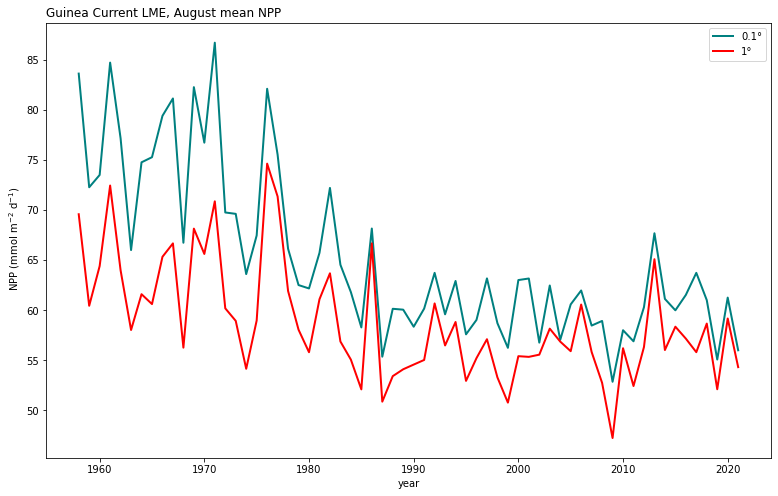

In [68]:
fig = plt.figure(figsize=(13,8))

ax = fig.add_subplot(1,1,1)
ax.set_title('Guinea Current LME, August mean NPP',loc='left')
v='photoC_TOT_zint'
ax.plot(years, ts_aug_lme_dict_x01[28][v]* convert, color='teal', linewidth=2, label='0.1°')
ax.plot(years, ts_aug_lme_dict_x1[28][v]* convert, color='red', linewidth=2, label='1°')
ax.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
ax.legend()


In [57]:
ds_fosi_x01.time.isel(time=163)

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1971, 8, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1971-08-16 12:00:00

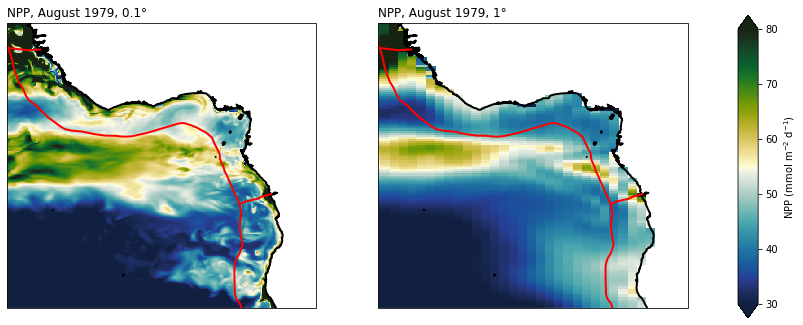

In [63]:
fig = plt.figure(figsize=(14,6))

############### 
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-20, 18, -20, 15], ccrs.PlateCarree())

ax.set_title('NPP, August 1979, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=254)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=80)

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='red',linewidth=2);
ax.coastlines('10m',linewidth=2)

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-20, 18, -20, 15], ccrs.PlateCarree())

ax.set_title('NPP, August 1979, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=254)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=80)

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='red',linewidth=2)
    
ax.coastlines('10m',linewidth=2)

###### NPP colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb_npp = plt.colorbar(pc, cax=cbar_ax,extend='both', label='NPP (mmol m$^{-2}$ d$^{-1}$)')

### Make timeseries for Sept for Benguela

In [64]:
ds_fosi_x01_sep = xr.Dataset()

m=8 #index for sept

for year in np.arange(1958,2022,1):
    
    print(year, m)
    
    ds_tmp = ds_fosi_x01.isel(time=m).drop(['time']).compute()
    
    ds_fosi_x01_sep = xr.concat([ds_fosi_x01_sep, ds_tmp],'time')
    
    m = m + 12

1958 8
1959 20
1960 32
1961 44
1962 56
1963 68
1964 80
1965 92
1966 104
1967 116
1968 128
1969 140
1970 152
1971 164
1972 176
1973 188
1974 200
1975 212
1976 224
1977 236
1978 248
1979 260
1980 272
1981 284
1982 296
1983 308
1984 320
1985 332
1986 344
1987 356
1988 368
1989 380
1990 392
1991 404
1992 416
1993 428
1994 440
1995 452
1996 464
1997 476
1998 488
1999 500
2000 512
2001 524
2002 536
2003 548
2004 560
2005 572
2006 584
2007 596
2008 608
2009 620
2010 632
2011 644
2012 656
2013 668
2014 680
2015 692
2016 704
2017 716
2018 728
2019 740
2020 752
2021 764


In [65]:
ds_fosi_x1_sept = ds_fosi_x1.sel(time = np.in1d(ds_fosi_x1['time.month'], 9)).compute()

In [70]:
lme_nums = [29]

#ts_by_lme_dict_x1 = {}
#ts_by_lme_dict_x01 = {}
ts_sep_lme_dict_x01 = {}
ts_sep_lme_dict_x1 = {}

for lme in lme_nums:
    print('lme = ', lme)
    mask_x1 = ones_x1.where(ds_lme_x1.lme_mask == lme)
    mask_x01 = ones.where(ds_lme_x01.lme_mask == lme)
    
    masked_area_x1 = area_m_x1.where(ds_lme_x1.lme_mask == lme)
    masked_area_x01 = area_m.where(ds_lme_x01.lme_mask == lme)
    
    #ds_tmp = xr.Dataset()
    #ds_tmp2 = xr.Dataset()
    ds_tmp3 = xr.Dataset()
    ds_tmp4 = xr.Dataset()
    
    for v in variables:
        
        #### annual mean x1
        #masked_var = ds_fosi_x1_ann[v].where(mask_x1==1)
        #ds_tmp[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))
        
        #### march mean x1
        masked_var = ds_fosi_x1_sept[v].where(mask_x1==1)

        ds_tmp4[v] = (masked_var * masked_area_x1).sum(dim=('nlon','nlat')) / masked_area_x1.sum(dim=('nlon','nlat'))
        
        #### annual mean x01
        #masked_var = ds_fosi_x01_ann[v].where(mask_x01==1)
        #ds_tmp2[v] = (masked_var * masked_area_x01).sum(dim=('nlon','nlat')) / masked_area_x01.sum(dim=('nlon','nlat'))
        
        #### march mean x01
        masked_var = ds_fosi_x01_sep[v].where(mask_x01==1)

        ds_tmp3[v] = (masked_var * masked_area_x01).sum(dim=('nlon','nlat')) / masked_area_x01.sum(dim=('nlon','nlat'))
        
    #ts_by_lme_dict_x1[lme] = ds_tmp
    #ts_by_lme_dict_x01[lme] = ds_tmp2
    ts_sep_lme_dict_x01[lme] = ds_tmp3
    ts_sep_lme_dict_x1[lme] = ds_tmp4

lme =  29


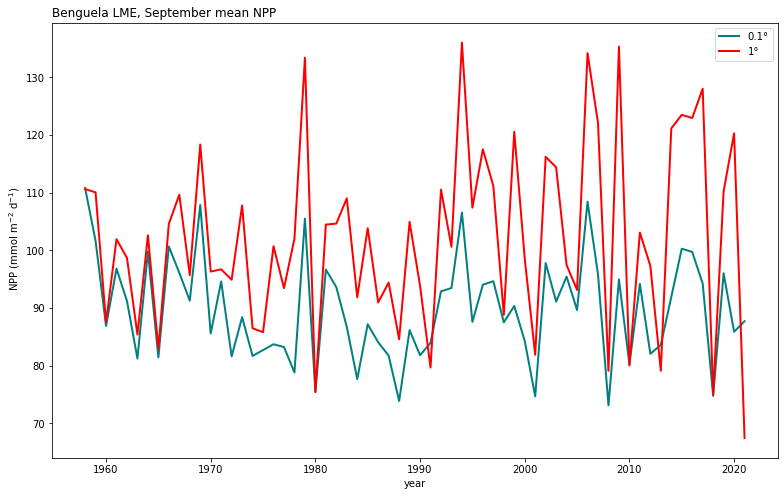

In [72]:
fig = plt.figure(figsize=(13,8))

ax = fig.add_subplot(1,1,1)
ax.set_title('Benguela LME, September mean NPP',loc='left')
v='photoC_TOT_zint'
ax.plot(years, ts_sep_lme_dict_x01[29][v]* convert, color='teal', linewidth=2, label='0.1°')
ax.plot(years, ts_sep_lme_dict_x1[29][v]* convert, color='red', linewidth=2, label='1°')
ax.set(xlabel='year',ylabel=' NPP (mmol m$^{-2}$ d$^{-1}$)');
ax.legend()


In [74]:
ds_fosi_x01.time[692]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2015, 9, 16, 0, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2015-09-16 00:00:00

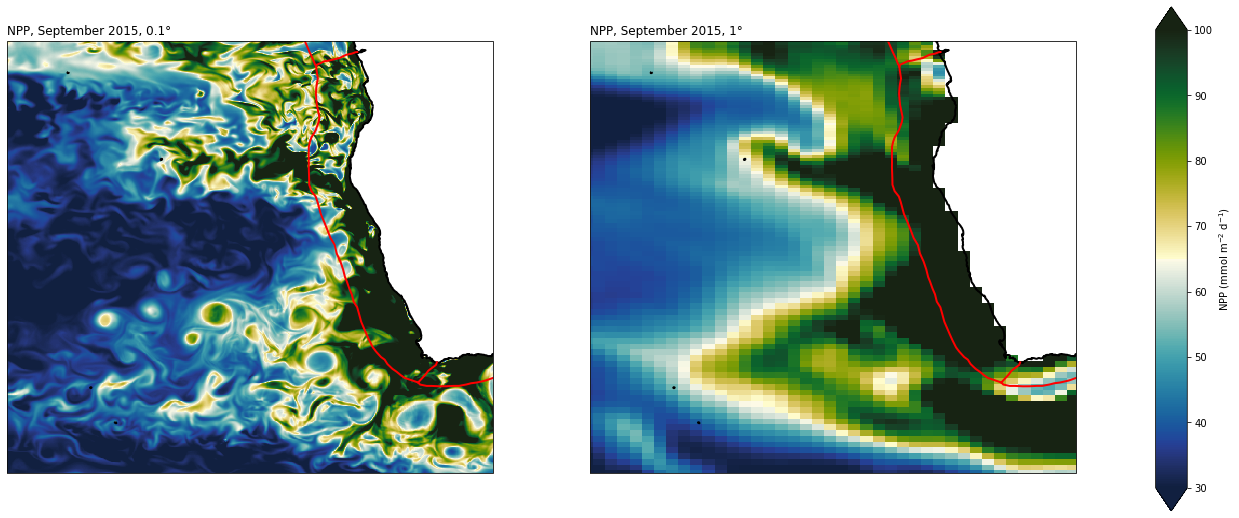

In [79]:
fig = plt.figure(figsize=(22,10))

############### 
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-20, 25, -45, -5], ccrs.PlateCarree())

ax.set_title('NPP, September 2015, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.photoC_TOT_zint.isel(time=692)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=100)

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='red',linewidth=2);
ax.coastlines('10m',linewidth=2)

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-20, 25, -45, -5], ccrs.PlateCarree())

ax.set_title('NPP, September 2015, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_fosi_x1.photoC_TOT_zint.isel(time=692)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=30,vmax=100)

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='red',linewidth=2)
    
ax.coastlines('10m',linewidth=2)

###### NPP colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb_npp = plt.colorbar(pc, cax=cbar_ax,extend='both', label='NPP (mmol m$^{-2}$ d$^{-1}$)')

In [59]:
#cluster.close()